In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -o -qq 'tiny-imagenet-200.zip'


--2020-08-24 08:35:30--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.2’

tiny-imagenet-200.z 100%[===================>] 236.61M  31.9MB/s    in 12s     

2020-08-24 08:35:47 (19.3 MB/s) - ‘tiny-imagenet-200.zip.2’ saved [248100043/248100043]



In [48]:
from tensorflow import keras
import os,sys
from matplotlib import pyplot
import pandas as pd

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np

In [49]:
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)


,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [50]:
# define a cnn model with four VGG blocks
def define_four_blocks_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(200, activation='softmax'))
    model.summary()
    return model

In [51]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.show()
    pyplot.close()


In [52]:
# run the test harness for evaluating a model
def run_test_harness(model):
    # compile model
    model.compile(loss='categorical_crossentropy',optimizer='adam',
              metrics=['accuracy'])
    # create data generators
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
        width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                 batch_size=256, class_mode='categorical', shuffle=True, seed=42)

    test_it = test_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=256, shuffle=True, seed=42)

    # Create EarlyStopping callback which stopps after 5 epochs of non-increasing accuracy
    early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
    # fit model
    history = model.fit(train_it, steps_per_epoch=390,
        validation_data=test_it, validation_steps=20, epochs=50, callbacks=[early])
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it))
    print('Test Accuracy > %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)      

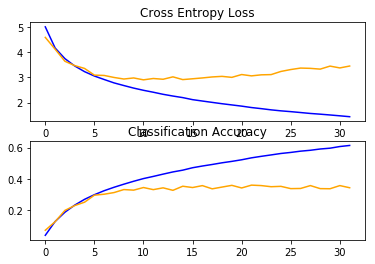

In [8]:
model4 = define_four_blocks_model()
run_test_harness(model4)

In [9]:
model4.save('4blocks-cnn-50-epochs-dropout.h5')

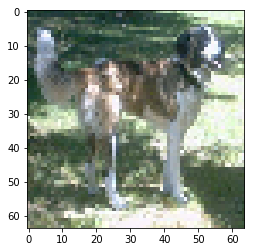

In [53]:
from tensorflow.keras.preprocessing import image

img = image.load_img('cats_and_dogs_filtered/validation/dogs/dog.2468.jpg', target_size=(64, 64))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
pyplot.imshow(img, cmap="binary")


In [54]:
layer_outputs = [layer.output for layer in model4.layers]

activation_model = Model(inputs=model4.input, outputs=layer_outputs)


In [55]:
activations = activation_model.predict(img_tensor)
len(activations)


15

In [24]:
layer_names = []
for layer in model4.layers:
    layer_names.append(layer.name)
    
layer_names


['conv2d_4',
 'max_pooling2d_4',
 'dropout_4',
 'conv2d_5',
 'max_pooling2d_5',
 'dropout_5',
 'conv2d_6',
 'max_pooling2d_6',
 'dropout_6',
 'conv2d_7',
 'max_pooling2d_7',
 'dropout_7',
 'flatten_1',
 'dense_2',
 'dense_3']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


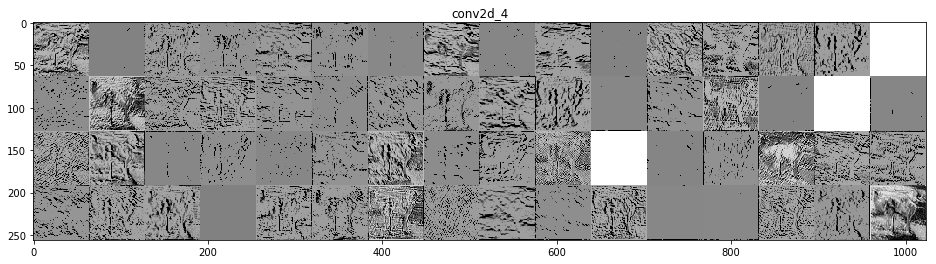

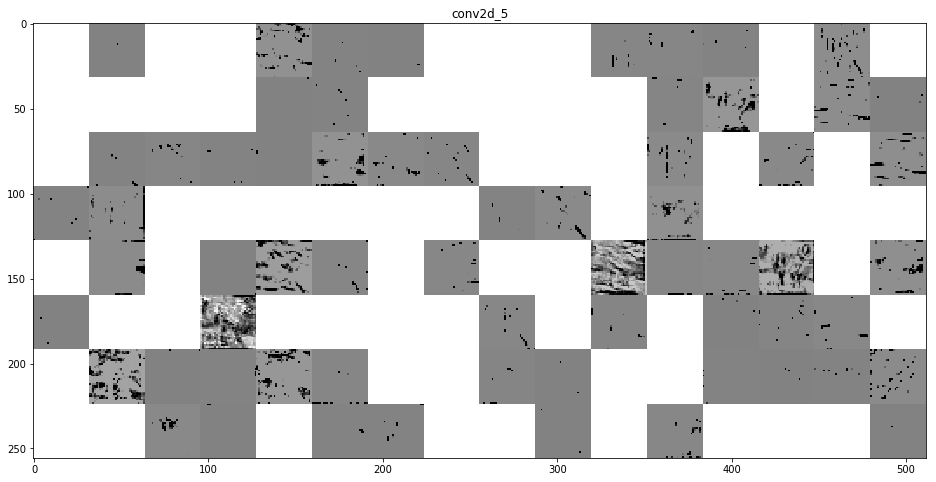

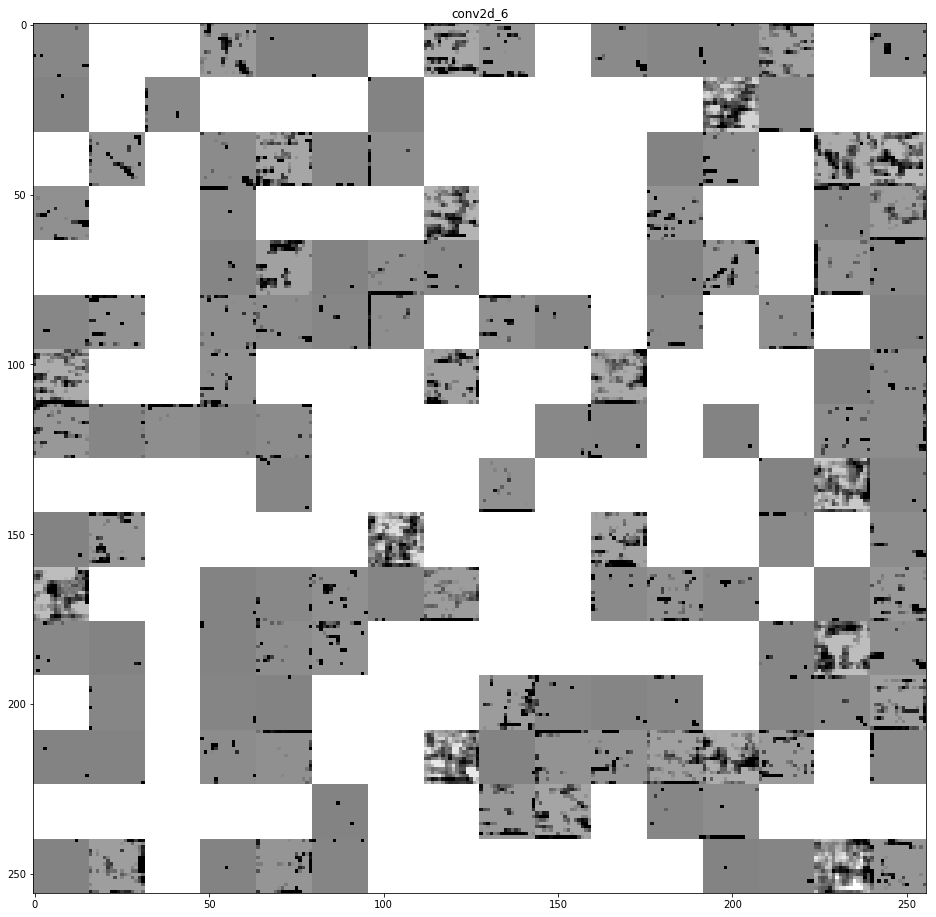

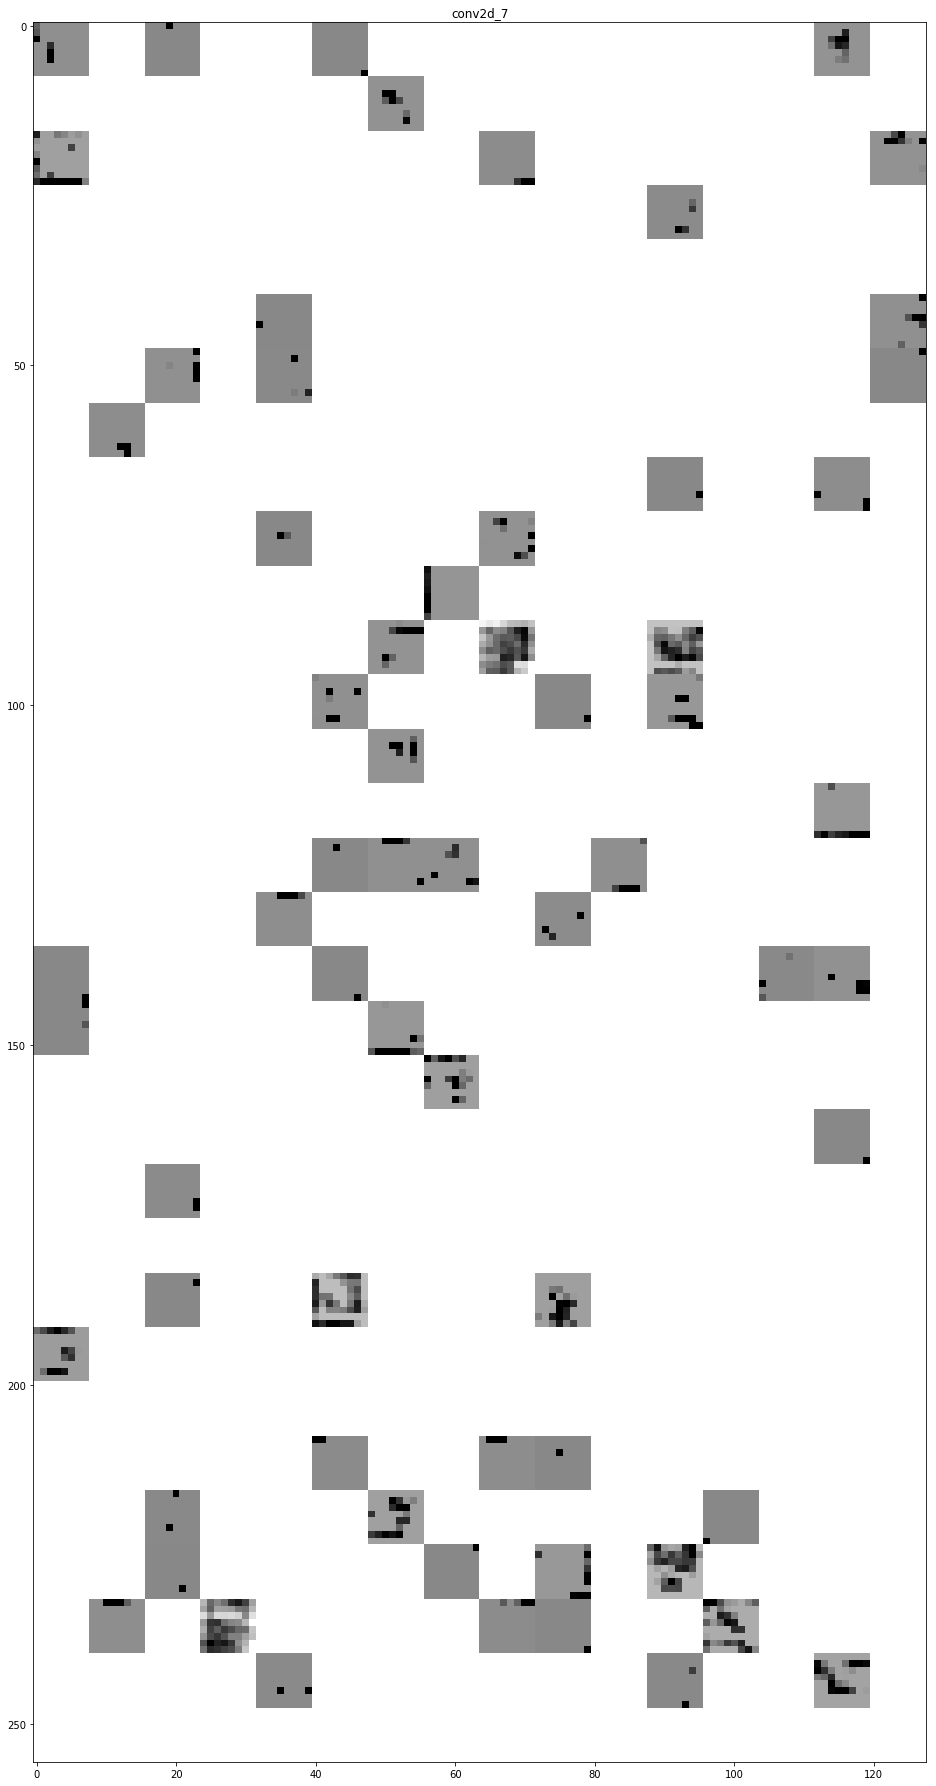

In [56]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model4.layers:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    
    if layer_name == 'flatten': 
        break
    if 'conv' not in layer_name:
        continue
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    pyplot.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    pyplot.title(layer_name)
    pyplot.grid(False)
    pyplot.imshow(display_grid, aspect='auto', cmap='binary')
    
pyplot.show()


In [57]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tf_keras_vis.saliency import Saliency
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize


In [58]:
!wget "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

import json
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
print("N of class={}".format(len(classlabel)))


--2020-08-25 05:43:47--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.52.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json.6’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.009s  

2020-08-25 05:43:47 (3.81 MB/s) - ‘imagenet_class_index.json.6’ saved [35363/35363]

N of class=1000


In [59]:
def pred_img(_img):
    img               = image.img_to_array(_img)
    img               = preprocess_input(img)
    y_pred            = model4.predict(img[np.newaxis,...])
    class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
    topNclass         = 5
    for i, idx in enumerate(class_idxs_sorted[:topNclass]):
        print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
              i + 1,classlabel[idx],idx,y_pred[0,idx]))


In [60]:
import json
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
print("N of class={}".format(len(classlabel)))


N of class=1000


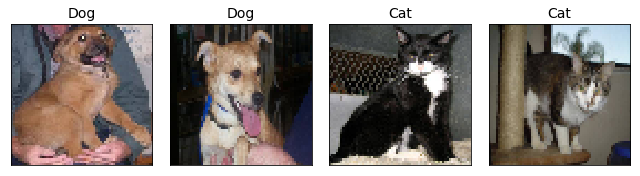

In [61]:
from tensorflow.keras.applications.vgg16 import preprocess_input


# Image titles
image_titles = ['Dog', 'Dog', 'Cat', 'Cat']

# Load images
img1 = image.load_img('cats_and_dogs_filtered/validation/dogs/dog.2470.jpg', target_size=(64, 64))
img2 = image.load_img('cats_and_dogs_filtered/validation/dogs/dog.2471.jpg', target_size=(64, 64))
img3 = image.load_img('cats_and_dogs_filtered/validation/cats/cat.2471.jpg', target_size=(64, 64))
img4 = image.load_img('cats_and_dogs_filtered/validation/cats/cat.2473.jpg', target_size=(64, 64))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

# Preparing input data
X = preprocess_input(images)

# Rendering
subplot_args = { 'nrows': 1, 'ncols': 4, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.show()


In [42]:
pred_img(img1)
pred_img(img2)
pred_img(img3)
pred_img(img4)

Top 1 predicted class:     Pr(Class=vine_snake         [index=59])=1.000
Top 2 predicted class:     Pr(Class=Scotch_terrier     [index=199])=0.000
Top 3 predicted class:     Pr(Class=rock_python        [index=62])=0.000
Top 4 predicted class:     Pr(Class=black_and_gold_garden_spider [index=72])=0.000
Top 5 predicted class:     Pr(Class=scorpion           [index=71])=0.000
Top 1 predicted class:     Pr(Class=cock               [index=7])=1.000
Top 2 predicted class:     Pr(Class=Scotch_terrier     [index=199])=0.000
Top 3 predicted class:     Pr(Class=rock_python        [index=62])=0.000
Top 4 predicted class:     Pr(Class=black_and_gold_garden_spider [index=72])=0.000
Top 5 predicted class:     Pr(Class=scorpion           [index=71])=0.000
Top 1 predicted class:     Pr(Class=macaw              [index=88])=1.000
Top 2 predicted class:     Pr(Class=Scotch_terrier     [index=199])=0.000
Top 3 predicted class:     Pr(Class=boa_constrictor    [index=61])=0.000
Top 4 predicted class:     Pr

In [45]:
# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
def loss(output):
    return (output[0][59], output[1][7], output[2][88], output[3][88])
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m


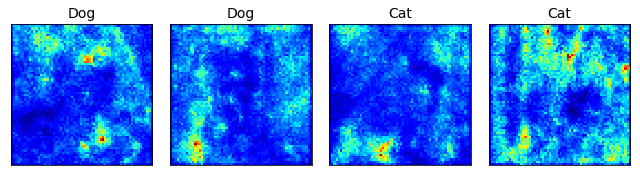

In [46]:
# Create Saliency object.
saliency = Saliency(model4,
                    model_modifier=model_modifier,
                    clone=False)

# Generate saliency map with smoothing that reduce noise by adding noise
saliency_map = saliency(loss,
                        X,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
plt.tight_layout()
plt.savefig('smoothgrad_pretrained.png')
plt.show()


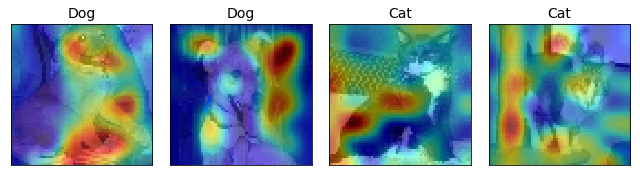

In [47]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model4,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              X,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
plt.tight_layout()
plt.show()
